In [7]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
%pip install pydicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
%pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
%pip install plotly
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/Users/ashleyxu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# %pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")

# print("Path to dataset files:", path)

In [9]:
import tarfile
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def extract_task1_files(root="./data"):
    tar = tarfile.open("data/BraTS2021_Training_Data.tar")
    tar.extractall("data/traning_data")
    tar.close()


In [10]:
extract_task1_files()

In [11]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
    
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{scan_type}.nii.gz'
        return self.read_file(scan_filename)

In [12]:
import plotly.graph_objects as go
import numpy as np


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale
    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 and 1/5 pixels for tumor tissue classes 1(core), 2(invaded) and 4(enhancing)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI'),
            generate_3d_scatter(**tumors[1], opacity=0.8, hover='all', name='Necrotic tumor core'),
            generate_3d_scatter(**tumors[2], opacity=0.4, hover='all', name='Peritumoral invaded tissue'),
            generate_3d_scatter(**tumors[4], opacity=0.4, hover='all', name='GD-enhancing tumor'),
        ], markers_created
    
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

In [13]:
reader = ImageReader('data/traning_data', img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)


/var/folders/5t/5kcb7x394tdf6wpn5rhw7h900000gn/T/ipykernel_84506/1794303141.py:15: UserWarning:

Argument 'value' is not valid and will be ignored.



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
flair    (155, 240, 240)
seg    (155, 240, 240)
[0 1 2 4]
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


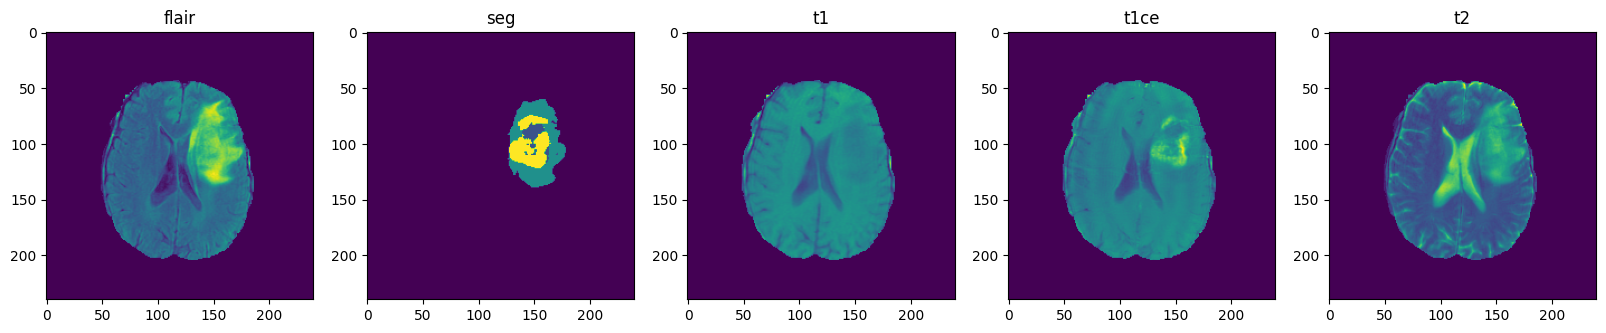

In [14]:

import tarfile
%pip install SimpleITK
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('data/traning_data/BraTS2021_01281/BraTS2021_01281_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])
    if name=='seg':
        print(np.unique(im))
    
    plt.subplot(1,5,i)
    plt.imshow(im)
    plt.title(name)

In [15]:
fig = viewer.get_3d_scan(0, 't1')
plotly.offline.iplot(fig)

In [16]:
#%pip install --upgrade nbformat
fig = viewer.get_3d_scan(9, 'flair')
plotly.offline.iplot(fig)

In [17]:
%pip install scikit-image
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [18]:
def get_approx_pixel_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

get_approx_pixel_count(data['segmentation'], mask=True) / get_approx_pixel_count(data['scan'], mask=True)

np.float64(0.0378232673703338)

In [19]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

([np.float64(0.578125),
  np.float64(0.3671875),
  np.float64(0.44516129032258067)],
 [np.float64(0.5859375),
  np.float64(0.359375),
  np.float64(0.45161290322580644)])

In [20]:
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][40]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

In [21]:
import pandas as pd
df = pd.read_csv('data/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
targets = dict(zip(df.BraTS21ID, df.MGMT_value))

In [22]:
%%time

features = []
for patient_idx in targets:
    try:
        data = reader.load_patient_scan(patient_idx)
        scan_px = get_approx_pixel_count(data['scan'], mask=True)
        tumor_px = get_approx_pixel_count(data['segmentation'], mask=True)
        core_px = get_approx_pixel_count(data['segmentation'], mask_idx=4)
        dimension = np.prod(data['scan'].shape)
        patient_features = [patient_idx, targets[patient_idx]]
        patient_features.extend([scan_px/dimension, tumor_px/dimension, tumor_px/scan_px, core_px/tumor_px])
        patient_features.extend(get_centroid(data['segmentation'], 4))
        features.append(patient_features)
    except FileNotFoundError:
        continue

CPU times: user 41.4 s, sys: 15.9 s, total: 57.3 s
Wall time: 1min


In [23]:
df = pd.DataFrame(
    features, columns=['idx', 'target', 'scan_pct', 'tumor_pct', 'tumor_ratio', 'core_ratio', 'x', 'y', 'z']
).set_index('idx')

df

target  scan_pct  tumor_pct  tumor_ratio  core_ratio         x  \
idx                                                                    
0          1  0.169896   0.006426     0.037823    0.569520  0.578125   
2          1  0.160032   0.021350     0.133414    0.125157  0.593750   
3          0  0.185514   0.011115     0.059917    0.241179  0.523438   
5          1  0.148663   0.013974     0.093995    0.191456  0.625000   
6          1  0.174226   0.015398     0.088381    0.190927  0.531250   
...      ...       ...        ...          ...         ...       ...   
1005       1  0.156157   0.012003     0.076863    0.324464  0.429688   
1007       1  0.178173   0.006243     0.035041    0.472722  0.625000   
1008       1  0.160777   0.004695     0.029204    0.166303  0.375000   
1009       0  0.161348   0.006054     0.037523    0.225106  0.437500   
1010       0  0.172383   0.005835     0.033846    0.306810  0.640625   

             y         z  
idx                       
0     0.367188  0.445161  
2     0.390625  0.516129  
3     0.476562  0.664516  
5     0.640625  0.729032  
6     0.281250  0.438710  
...        ...       ...  
1005  0.617188  0.509677  
1007  0.601562  0.316129  
1008  0.500000  0.503226  
1009  0.437500  0.580645  
1010  0.625000  0.341935  

[577 rows x 8 columns]

In [24]:
fig = px.histogram(
    df, x="tumor_pct", color="target", marginal="box",
    nbins=100, barmode='relative'
)
fig.show()

In [25]:
fig = px.histogram(
    df, x="tumor_ratio", color="target", marginal="box",
    nbins=100, barmode='relative'
)
fig.show()

In [26]:
from sklearn.model_selection import train_test_split

X, y = df.drop('target', axis=1).values, df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
print(f'train: {X_train.shape[0]} scans, test: {X_test.shape[0]} scans')

train: 490 scans, test: 87 scans


In [27]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, log_loss

models = [
    RidgeClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=60),
]

def train_ensemble(models:list, data:tuple, print_individual:bool=False):
    X_train, X_test, y_train, y_test = data
    full_preds = []
    for clf in models:
        clf.fit(X_train, y_train)
        try:
            preds = clf.predict_proba(X_test)[:, 1]
        except AttributeError:
            preds = clf.predict(X_test)
        full_preds.append(preds)
        if print_individual:
            print(
                clf.__class__.__name__.ljust(25), '  scores:',
                roc_auc_score(y_test, preds), 'ROC AUC; ',
                log_loss(y_test, preds), 'loss.'
            )
    return full_preds

ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), True)
print('average:'.rjust(35), roc_auc_score(y_test, np.mean(ensemble_predictions, 0)), 'ROC AUC')


RidgeClassifier             scores: 0.46895604395604396 ROC AUC;  19.05756386091252 loss.
DecisionTreeClassifier      scores: 0.6024725274725276 ROC AUC;  14.914615195496758 loss.
KNeighborsClassifier        scores: 0.593956043956044 ROC AUC;  0.6848073774524429 loss.
                           average: 0.5840659340659341 ROC AUC


In [28]:
split_scores = []
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    models = [RidgeClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=60)]
    ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), False)
    split_scores.append(roc_auc_score(y_test, np.mean(ensemble_predictions, 0)))
print('mean', np.mean(split_scores), 'max', np.max(split_scores))

mean 0.5763554422287333 max 0.663142857142857


In [29]:
split_scores = []
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    y_test = np.random.permutation(y_test)
    models = [RidgeClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=60)]
    ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), False)
    split_scores.append(roc_auc_score(y_test, np.mean(ensemble_predictions, 0)))
print('mean', np.mean(split_scores), 'max', np.max(split_scores))

mean 0.4877598302957141 max 0.6044690603514131
